In [ ]:
# INCEPTION V3 NEURAL NETWORK TO CLASSIFY IMAGES AS HAVING POTHOLES OR NOT 

# Sources cited:
# https://keras.io/guides/transfer_learning/
# https://keras.io/api/applications/#usage-examples-for-image-classification-models
# https://keras.io/api/data_loading/
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# https://datascience.stackexchange.com/questions/104572/does-validation-split-in-tf-keras-preprocessing-image-dataset-from-directory-res

# importing files and libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import glob
import keras
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score , recall_score, f1_score
from sklearn.metrics import top_k_accuracy_score


In [ ]:
# Mounting Google drive
# The dataset is stored on the drive

from google.colab import drive 
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
filepath = '/content/drive/MyDrive/Senior_Design/'

In [ ]:
# Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "balajisath" # username from the json file
os.environ['KAGGLE_KEY'] = "75272a5becccf25ffbceee62d646c0a9" # key from the json file

In [ ]:
%cd /content/drive/MyDrive/Senior_Design/Data

/content/drive/MyDrive/Senior_Design/Data


In [ ]:
#!kaggle datasets download -d felipemuller5/nienaber-potholes-2-complex --unzip

100% 32.7G/32.7G [18:09<00:00, 31.8MB/s]
100% 32.7G/32.7G [18:09<00:00, 32.2MB/s]


In [ ]:
#!kaggle datasets download -d felipemuller5/nienaber-potholes-1-simplex --unzip

100% 21.6G/21.6G [12:28<00:00, 41.3MB/s]
100% 21.6G/21.6G [12:28<00:00, 31.0MB/s]


In [ ]:
#folder='/content/drive/MyDrive/CS523_Deep_Learning/Data/train/c'

#filelist = glob.glob(folder + '0' + '/*.jpg')
#train_images = np.array([np.array(Image.open(fname)) for fname in filelist])
#train_labels = np.zeros((train_images.shape[0],), dtype=int)

#for i in range(1,10):
#    folder_i = folder+str(i)
#    filelist = glob.glob(folder_i + '/*.jpg')
#    temp=np.array([np.array(Image.open(fname)) for fname in filelist])
#    train_images = np.vstack((train_images, temp))
#    train_labels = np.hstack((train_labels, np.zeros((temp.shape[0],), dtype=int) + i))


In [ ]:
#folder='/content/drive/MyDrive/CS523_Deep_Learning/Data/TestData/c'

#filelist = glob.glob(folder + '0' + '/*.jpg')
#test_images = np.array([np.array(Image.open(fname)) for fname in filelist])
#test_labels = np.zeros((test_images.shape[0],), dtype=int)

#for i in range(1,10):
#    folder_i = folder+str(i)
#    filelist = glob.glob(folder_i + '/*.jpg')
#    temp=np.array([np.array(Image.open(fname)) for fname in filelist])
#    test_images = np.vstack((test_images, temp))
#    test_labels = np.hstack((test_labels, np.zeros((temp.shape[0],), dtype=int) + i))

In [ ]:
# Extracting training, validation and test data sets

train_ds1 = tf.keras.utils.image_dataset_from_directory(
    directory=filepath+'Data/Train1',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    validation_split=0.1,
    subset='training',
    image_size=(480, 640))

train_ds2 = tf.keras.utils.image_dataset_from_directory(
    directory=filepath+'Data/Train2',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    validation_split=0.1,
    subset='training',
    image_size=(480, 640))

train_ds=train_ds1.concatenate(train_ds2)

val_ds1 = tf.keras.utils.image_dataset_from_directory(
    directory=filepath+'Data/Train1',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    validation_split=0.1,
    subset='validation',
    image_size=(480, 640))

val_ds2 = tf.keras.utils.image_dataset_from_directory(
    directory=filepath+'Data/Train2',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    validation_split=0.1,
    subset='validation',
    image_size=(480, 640))

val_ds=val_ds1.concatenate(val_ds2)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=filepath+'Data/Test1',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    seed=42,
    shuffle=True,
    image_size=(480, 640))

Found 7110 files belonging to 2 classes.
Using 6399 files for training.
Found 4736 files belonging to 2 classes.
Using 4263 files for training.
Found 7110 files belonging to 2 classes.
Using 711 files for validation.
Found 4736 files belonging to 2 classes.
Using 473 files for validation.
Found 984 files belonging to 2 classes.


In [ ]:
# Inception V3 model with transfer learning

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(480, 640, 3))

base_model.trainable = False
inputs = keras.Input(shape=(480, 640, 3))

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
inputs = scale_layer(inputs)

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x) 

x = Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x) 

predictions = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs=predictions)

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

history=model.fit(train_ds, epochs=10, validation_data=val_ds)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 480, 640, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 13, 18, 2048)      21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                           

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


334/334 [==============================] - 121s 325ms/step - loss: 3.2285 - accuracy: 0.7049 - val_loss: 0.6058 - val_accuracy: 0.7804
Epoch 2/10
334/334 [==============================] - 107s 313ms/step - loss: 0.5459 - accuracy: 0.7677 - val_loss: 0.5446 - val_accuracy: 0.7804
Epoch 3/10
334/334 [==============================] - 107s 313ms/step - loss: 0.5272 - accuracy: 0.7754 - val_loss: 0.5262 - val_accuracy: 0.7804
Epoch 4/10
334/334 [==============================] - 107s 313ms/step - loss: 0.5182 - accuracy: 0.7765 - val_loss: 0.4711 - val_accuracy: 0.7804
Epoch 5/10
334/334 [==============================] - 106s 310ms/step - loss: 0.5052 - accuracy: 0.7832 - val_loss: 0.5771 - val_accuracy: 0.7812
Epoch 6/10
334/334 [==============================] - 108s 316ms/step - loss: 0.5141 - accuracy: 0.7784 - val_loss: 0.4633 - val_accuracy: 0.7804
Epoch 7/10
334/334 [==============================] - 107s 314ms/step - loss: 0.5031 - accuracy: 0.7765 - val_loss: 0.5175 - val_accura

In [ ]:
# Inception V3 model with fine tuning

base_model.trainable = True
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath+'Models/InceptionV3_Sample_Net', monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

history=model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[checkpoint])


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 480, 640, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 13, 18, 2048)      21802784  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_7 (Dropout)         (None, 1024)              0         
                                                           

Epoch 1/15


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


334/334 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.7788
Epoch 1: loss improved from inf to 0.49302, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 173s 479ms/step - loss: 0.4930 - accuracy: 0.7788 - val_loss: 0.4287 - val_accuracy: 0.7922
Epoch 2/15
334/334 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8274
Epoch 2: loss improved from 0.49302 to 0.41331, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 162s 478ms/step - loss: 0.4133 - accuracy: 0.8274 - val_loss: 0.4234 - val_accuracy: 0.8480
Epoch 3/15
334/334 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8582
Epoch 3: loss improved from 0.41331 to 0.33818, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 162s 478ms/step - loss: 0.3382 - accuracy: 0.8582 - val_loss: 0.3976 - val_accuracy: 0.8133
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.8739
Epoch 4: loss improved from 0.33818 to 0.30588, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 164s 483ms/step - loss: 0.3059 - accuracy: 0.8739 - val_loss: 0.2721 - val_accuracy: 0.8860
Epoch 5/15
334/334 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.8907
Epoch 5: loss improved from 0.30588 to 0.25274, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 159s 470ms/step - loss: 0.2527 - accuracy: 0.8907 - val_loss: 0.3083 - val_accuracy: 0.8716
Epoch 6/15
334/334 [==============================] - ETA: 0s - loss: 0.2188 - accuracy: 0.9055
Epoch 6: loss improved from 0.25274 to 0.21878, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 161s 474ms/step - loss: 0.2188 - accuracy: 0.9055 - val_loss: 0.2310 - val_accuracy: 0.9003
Epoch 7/15
334/334 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9217
Epoch 7: loss improved from 0.21878 to 0.18661, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 161s 477ms/step - loss: 0.1866 - accuracy: 0.9217 - val_loss: 0.3657 - val_accuracy: 0.8159
Epoch 8/15
334/334 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9332
Epoch 8: loss improved from 0.18661 to 0.15703, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 160s 473ms/step - loss: 0.1570 - accuracy: 0.9332 - val_loss: 0.2040 - val_accuracy: 0.9248
Epoch 9/15
334/334 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9444
Epoch 9: loss improved from 0.15703 to 0.13896, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 161s 475ms/step - loss: 0.1390 - accuracy: 0.9444 - val_loss: 0.1897 - val_accuracy: 0.9358
Epoch 10/15
334/334 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9574
Epoch 10: loss improved from 0.13896 to 0.11093, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 162s 479ms/step - loss: 0.1109 - accuracy: 0.9574 - val_loss: 0.2112 - val_accuracy: 0.9231
Epoch 11/15
334/334 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9675
Epoch 11: loss improved from 0.11093 to 0.08742, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 160s 473ms/step - loss: 0.0874 - accuracy: 0.9675 - val_loss: 0.2502 - val_accuracy: 0.9299
Epoch 12/15
334/334 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9646
Epoch 12: loss did not improve from 0.08742
334/334 [==============================] - 116s 340ms/step - loss: 0.0968 - accuracy: 0.9646 - val_loss: 0.1790 - val_accuracy: 0.9392
Epoch 13/15
334/334 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9741
Epoch 13: loss improved from 0.08742 to 0.07130, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 162s 477ms/step - loss: 0.0713 - accuracy: 0.9741 - val_loss: 0.1738 - val_accuracy: 0.9485
Epoch 14/15
334/334 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9800
Epoch 14: loss improved from 0.07130 to 0.05625, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 159s 470ms/step - loss: 0.0562 - accuracy: 0.9800 - val_loss: 0.1800 - val_accuracy: 0.9519
Epoch 15/15
334/334 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9820
Epoch 15: loss improved from 0.05625 to 0.05200, saving model to /content/drive/MyDrive/Senior_Design/Models/InceptionV3_Sample_Net


334/334 [==============================] - 164s 483ms/step - loss: 0.0520 - accuracy: 0.9820 - val_loss: 0.1521 - val_accuracy: 0.9620


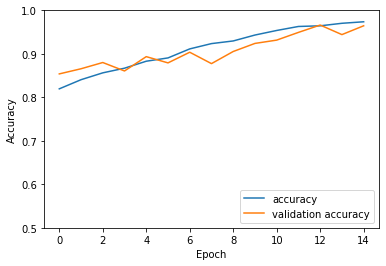

In [ ]:
# plots

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
model=keras.models.load_model(filepath+'Models/InceptionV3_Sample_Net')
# Use filepath+'Models/InceptionV3_Sample_Net' if you want to access a sample net already trained by us

In [ ]:
# Test Accuracy

test_loss, test_acc = model.evaluate(test_ds)
print(test_acc)

31/31 [==============================] - 46s 1s/step - loss: 0.4057 - accuracy: 0.9136
0.9136179089546204


In [ ]:
# y_pred and y_true for calculating metrics

y_pred_t=model.predict(test_ds)
y_pred=np.argmax(y_pred_t, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)

31/31 [==============================] - 49s 2s/step


In [ ]:
# Top 2 accuracy

#top_k_accuracy_score(y_true, y_pred_t, k=2)

In [1]:
# Confusion matrix

#cm=confusion_matrix(y_true, y_pred)
#print(cm)

In [2]:
# Precision

#print(precision_score(y_true,y_pred,average='micro'))

In [3]:
# Recall

#print(recall_score(y_true,y_pred,average='micro'))

In [4]:
# F1 Score

#print(f1_score(y_true,y_pred,average='micro'))

In [5]:
# Classification Report 

#print(classification_report(y_true, y_pred))